In [0]:
!git clone https://github.com/MathieuNls/clever-challenge.git

Cloning into 'clever-challenge'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 82 (delta 11), reused 18 (delta 4), pack-reused 52
Unpacking objects: 100% (82/82), done.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
pd.set_option('display.max_columns',50)

# Peek sample and res

In [0]:
pd.read_csv('clever-challenge/seq/sample.csv')

,event_id,timestamp,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,811067,1479737872,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,0,0,0,0,9230,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
1,811068,1480609381,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,1,0,0,0,9231,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
2,811069,1480670042,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,2442,172188,0,172076,9230,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
3,811070,1480673885,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,0,0,0,0,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
4,811071,1480673919,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,21,12,0,0,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
5,811072,1480692926,0,1,1,3,0.793341,31,33,1277.000000,2,11.053866,3,34,0,17,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
6,811073,1480697906,0,1,1,1,0.000000,20,10,1103.000000,2,11.111505,1,37,0,20,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
7,811074,1481216829,0,1,1,2,0.070304,119,108,952.500000,2,17.117558,2,38,0,21,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
8,811075,1481290988,0,1,3,9,1.330891,260,185,670.111111,2,17.975880,9,40,0,23,9232,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
9,811076,1481549433,1,6,788,6801,7.347146,491555,44374,195.737686,1,6.827746,2226,182400,0,182282,9230,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0


In [0]:
pd.read_csv('clever-challenge/seq/res.csv').head(3)

,event_id,res_id
0,811067,15325277
1,811067,15325278
2,811067,15325279


# Preprocessing

Some features are duplicate or useless.

In [0]:
sample = pd.read_csv('clever-challenge/seq/sample.csv')
res = pd.read_csv('clever-challenge/seq/res.csv')

##f11, f16, f19, f22-f30 all 0

In [0]:
for col in sample.columns:
  print(sample[col].value_counts())

## f14, f21 are the same

In [0]:
sample.loc[sample['f14']!=sample['f21']]

,event_id,timestamp,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21


## drop useless cols

In [0]:
sample = sample.drop(['f11','f16','f19'],axis=1).drop(sample.iloc[:,-10:], axis=1)

# Numerical feature engineering

I tried to plot features to find some strong correlation between `features` and `feature-event_id`.

## plot

### correlation map

In [0]:
sample.corr()

,event_id,timestamp,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20
event_id,1.000000,0.968157,-0.062451,-0.065558,-0.032485,-0.028137,-0.058749,-0.019562,-0.030426,-0.035067,0.232250,0.290269,-0.047045,-0.076813,-0.037217,-0.021627,0.235763,0.026793,0.034132,0.012636,0.022148
timestamp,0.968157,1.000000,-0.022233,-0.088378,-0.047217,-0.042574,-0.046547,-0.034170,-0.033192,-0.024686,0.246377,0.297504,-0.050675,-0.092966,-0.031344,-0.025514,0.267152,0.051418,0.055992,0.018443,0.026337
class,-0.062451,-0.022233,1.000000,0.103035,0.036736,0.023801,0.393084,0.013668,-0.001843,-0.082280,0.253569,-0.187449,0.037823,-0.051034,-0.023714,0.023735,0.201738,0.012187,0.030515,-0.020873,-0.006312
f1,-0.065558,-0.088378,0.103035,1.000000,0.278444,0.240047,0.320466,0.185523,0.145841,-0.043811,0.134195,-0.026696,0.200120,0.082678,0.165365,-0.006652,0.011984,0.053084,0.063039,0.050090,0.103025
f2,-0.032485,-0.047217,0.036736,0.278444,1.000000,0.979283,0.225155,0.943013,0.181663,-0.016100,0.082983,-0.023617,0.284463,0.032855,0.067072,-0.002088,-0.007397,0.001227,0.005025,-0.001991,-0.000715
f3,-0.028137,-0.042574,0.023801,0.240047,0.979283,1.000000,0.188181,0.963069,0.184020,-0.014147,0.049478,-0.020733,0.285013,0.016775,0.035502,0.000871,-0.013353,-0.002709,-0.001465,0.000588,0.001825
f3.1,-0.058749,-0.046547,0.393084,0.320466,0.225155,0.188181,1.000000,0.105682,0.194054,-0.141896,0.477435,-0.188952,0.352916,0.014966,0.127463,-0.004959,0.189225,0.048139,0.096023,-0.032018,-0.008706
f4,-0.019562,-0.034170,0.013668,0.185523,0.943013,0.963069,0.105682,1.000000,0.031629,-0.008160,0.004678,-0.015504,0.050957,0.001543,0.006144,0.001639,-0.010738,-0.004247,-0.003977,-0.001971,-0.001561
f5,-0.030426,-0.033192,-0.001843,0.145841,0.181663,0.184020,0.194054,0.031629,1.000000,-0.009168,0.049926,0.001852,0.640374,0.025972,0.042421,-0.002654,-0.008462,0.006095,-0.001708,0.033504,0.049373
f6,-0.035067,-0.024686,-0.082280,-0.043811,-0.016100,-0.014147,-0.141896,-0.008160,-0.009168,1.000000,0.201435,0.334860,-0.023228,-0.024454,0.004791,-0.025380,-0.057350,0.020695,0.031997,0.007425,0.010554


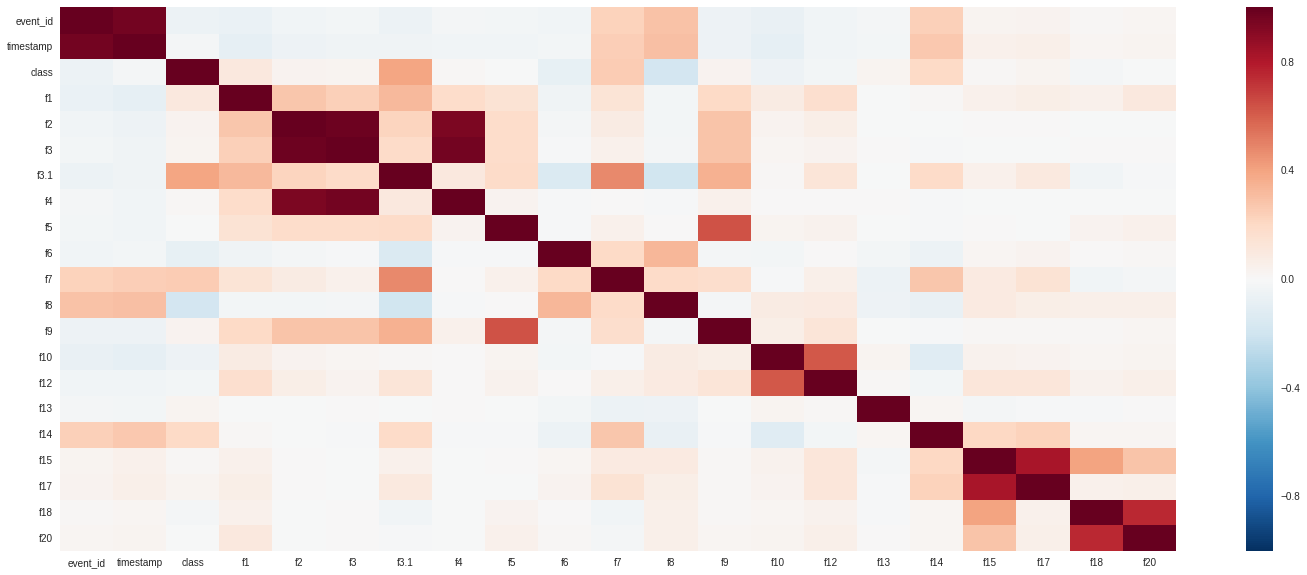

In [0]:
plt.figure(figsize=(25,10))
sns.heatmap(sample.corr())

## strong corr in time & f8's max

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


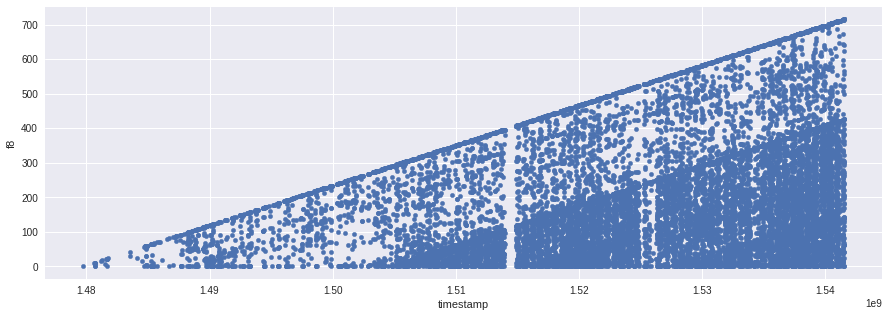

In [0]:
sample.plot(x='timestamp',y='f8', figsize=(15,5),kind='scatter')

**bold text**## event counts / time

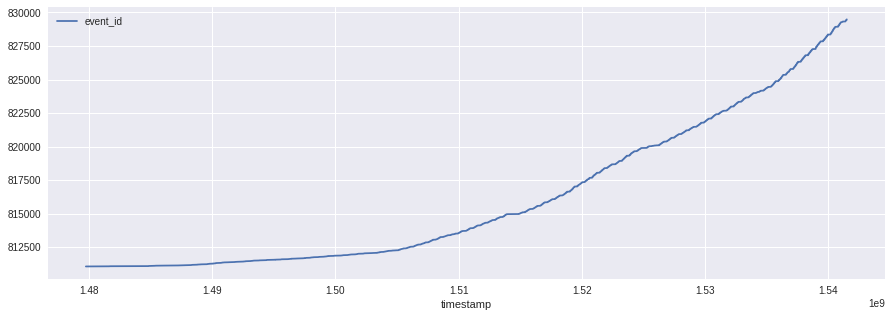

In [0]:
sample.plot(x='timestamp',y='event_id', figsize=(15,5))

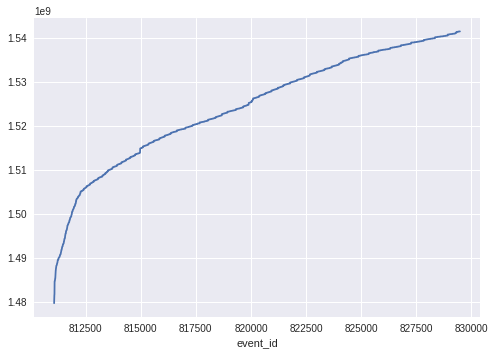

In [0]:
sample.set_index('event_id')['timestamp'].plot()

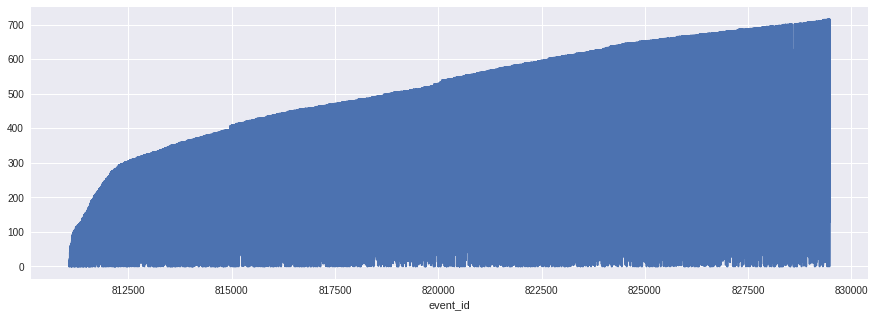

In [0]:
sample.set_index('event_id')['f8'].plot(figsize=(15,5))

## Resource usage

In [0]:
res.set_index('event_id')

### f3 is res_counts

In [0]:
res['res_id'].value_counts()

15552206    235
15450223    199
15548173    198
15543324    192
15456317    173
15577514    146
15548172    141
15551372    136
15548163    131
15557636    131
15450222    129
15574446    120
15543323    117
15557253    113
15575160    111
15565479    110
15457531    110
15548084    110
15551363    107
15565478    107
15552205    106
15457357    104
15576101    102
15457464    100
15452032     97
15449984     95
15513365     94
15544662     94
15459069     93
15556441     92
           ... 
15597804      1
15599853      1
15655152      1
15657201      1
15659250      1
15661299      1
15646964      1
15649013      1
15651062      1
15638776      1
15614180      1
15624417      1
15663308      1
15622368      1
15667406      1
15669455      1
15720656      1
15724754      1
15726803      1
15712468      1
15714517      1
15716566      1
15718615      1
15704280      1
15706329      1
15708378      1
15710427      1
15700190      1
15702239      1
15728640      1
Name: res_id, Length: 42

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


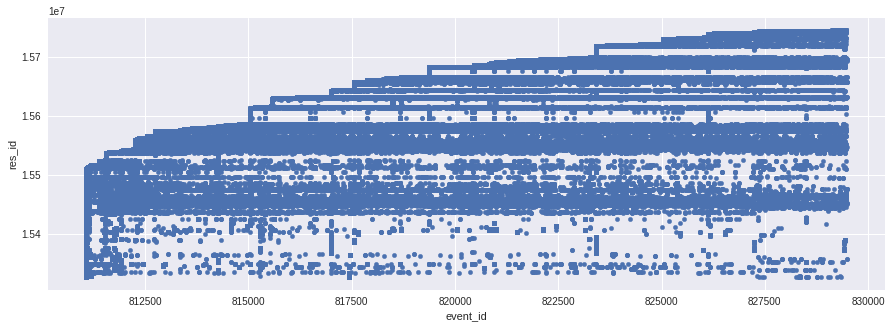

In [0]:
res.plot(x='event_id', y='res_id', kind='scatter', figsize=(15,5))

# Classifier

- My original idea is to build a predictor and a classifier, the output of the predictor(prediction of features) as the input of classifier, but the performance of classifier is not good, thus killed this idea.

- The first half of data has too many noise and a sharper trend in `event_counts` vs `timestamp`, so I tried to drop the first half, and classifier performance improved.

- Tried to include time feature by translating `timestamp` into `minute`, `hour`, etc. They improved the classifier performance, please check the `feature importance` part.

In [0]:
unixtime = pd.to_datetime(sample['timestamp'], unit='s')
sample = pd.concat([sample, unixtime.apply(lambda x: x.minute).rename('minute'), 
                    unixtime.apply(lambda x: x.quarter).rename('quarter'), 
                    unixtime.apply(lambda x: x.hour).rename('hour'), 
                    unixtime.apply(lambda x: x.dayofweek).rename('dayofweek'), 
                    unixtime.apply(lambda x: x.day).rename('day'), 
                    unixtime.apply(lambda x: x.week).rename('week'), 
                    unixtime.apply(lambda x: x.month).rename('month'), 
                    unixtime.apply(lambda x: x.year).rename('year')], axis=1)

In [0]:
tmp = sample.set_index('event_id').join(pd.DataFrame(res['event_id'].value_counts().rename('res_counts')))
tmp = tmp.loc[tmp['res_counts'].notnull()]

In [0]:
unixtime = pd.to_datetime(tmp['timestamp'],unit='s')

In [0]:
tmp = pd.concat([tmp, unixtime.apply(lambda x: x.minute).rename('minute'), 
                    unixtime.apply(lambda x: x.quarter).rename('quarter'), 
                    unixtime.apply(lambda x: x.hour).rename('hour'), 
                    unixtime.apply(lambda x: x.dayofweek).rename('dayofweek'), 
                    unixtime.apply(lambda x: x.day).rename('day'), 
                    unixtime.apply(lambda x: x.week).rename('week'), 
                    unixtime.apply(lambda x: x.month).rename('month'), 
                    unixtime.apply(lambda x: x.year).rename('year')], axis=1)

In [0]:
tmp = tmp.loc[817020:]

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tmp.drop(['timestamp','res_counts','class'], axis=1), tmp['class'], random_state=1984)

## with time feature

In [0]:
model = lgb.LGBMClassifier(objective='binary')
model.fit(tmp.drop(['timestamp','res_counts','class'], axis=1),tmp['class'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
pred = model.predict(tmp.drop(['timestamp','res_counts','class'], axis=1))
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(tmp['class'], pred))
print(confusion_matrix(tmp['class'], pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9992
           1       0.83      0.77      0.80      8316

   micro avg       0.82      0.82      0.82     18308
   macro avg       0.83      0.82      0.82     18308
weighted avg       0.83      0.82      0.82     18308

[[8729 1263]
 [1944 6372]]


### feature importance

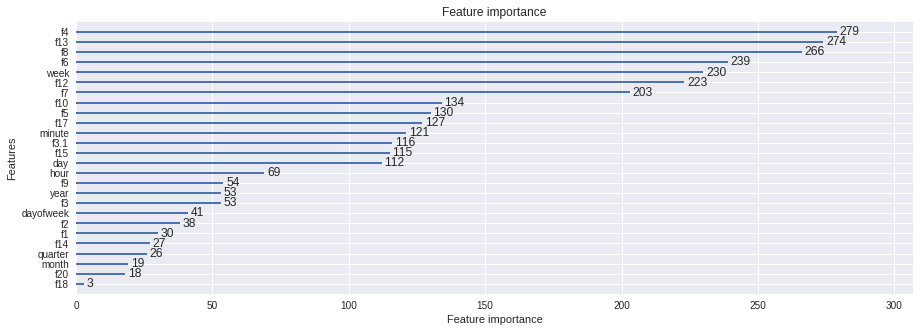

In [0]:
lgb.plot_importance(model, figsize=(15,5))

## without time feature

In [0]:
pred = model.predict(tmp.drop(['timestamp','res_counts','class'], axis=1))
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(tmp['class'], pred))
print(confusion_matrix(tmp['class'], pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      9992
           1       0.82      0.75      0.78      8316

   micro avg       0.81      0.81      0.81     18308
   macro avg       0.81      0.81      0.81     18308
weighted avg       0.81      0.81      0.81     18308

[[8670 1322]
 [2104 6212]]


## later half data with time feature

In [0]:
model = lgb.LGBMClassifier(objective='binary')
model.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### valid on train set

In [0]:
pred = model.predict(tmp.drop(['timestamp','res_counts','class'], axis=1))
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(tmp['class'], pred))
print(confusion_matrix(tmp['class'], pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6744
           1       0.86      0.80      0.83      5675

   micro avg       0.85      0.85      0.85     12419
   macro avg       0.85      0.84      0.84     12419
weighted avg       0.85      0.85      0.85     12419

[[5987  757]
 [1150 4525]]


### test on test set

In [0]:
pred = model.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1678
           1       0.77      0.74      0.76      1427

   micro avg       0.78      0.78      0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105

[[1367  311]
 [ 368 1059]]


# Predictor

Input are 10 timestamps of 25 features(original + `minute`, `hour`, etc.) extracted, input shape (-1, 10, 25)

Output is the next `class` value.

Evaluation Metric: Accuracy

## Preprocessing

Normalize and generate input.

In [0]:
tmp = tmp.drop(['year', 'res_counts', 'timestamp'], axis=1)
class_0 = tmp.pop('class')

In [0]:
from sklearn.preprocessing import MinMaxScaler
need_to_normalize = ['f2', 'f4', 'f5', 'f6', 'f8', 'f9', 'f10', 'f12', 'f13', 'f15', 'f17', 'f18', 'f20']
features_to_normalize = tmp[need_to_normalize].astype(np.float32)
for col in need_to_normalize:
    features_to_normalize[col] /= np.max(features_to_normalize[col])
for col in features_to_normalize:
    tmp[col] = features_to_normalize[col]

In [0]:
def create_dataset(dataset_x, dataset_y, length_x, lentgh_y):
    data_X = []
    data_Y = []
    head_index = 0
    tail_index = head_index + length_x
    while (tail_index + lentgh_y <= tmp.shape[0]):
        data_x = dataset_x.iloc[head_index: tail_index].values
        data_y = dataset_y.iloc[tail_index: tail_index + lentgh_y].values
        data_X.append(data_x)
        data_Y.append(data_y)
        head_index += 1
        tail_index += 1
    #return np.array(data_X), np.array(data_Y)
    return data_X, data_Y
x,y = create_dataset(tmp, class_0, 10, 1)

In [0]:
x = np.array(x)
y = np.array(y)

## LSTM

Loss metric: validation set mean squared error

Min `val_loss`: 0.2483, Accuracy: 0.545

In [0]:
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import Dense
from keras.models import Sequential

#callback
model = Sequential()
model.add(CuDNNLSTM(units = 100, input_shape=(10,25)))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100)               50800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

callback = EarlyStopping(patience=15)
x_train, x_mid, y_train, y_mid = train_test_split(x, y, random_state=1984)
x_val, x_test, y_val, y_test = train_test_split(x_mid, y_mid, random_state=1984)

model.fit(x = x_train,
          y = y_train,
          epochs = 100,
          batch_size = 128,
          callbacks = [callback],
          validation_data = (x_val, y_val)
        )

Train on 13723 samples, validate on 3431 samples
Epoch 1/100
13723/13723 [==============================] - 2s 124us/step - loss: 0.3065 - val_loss: 0.2539
Epoch 2/100
13723/13723 [==============================] - 1s 65us/step - loss: 0.2480 - val_loss: 0.2495
Epoch 3/100
13723/13723 [==============================] - 1s 65us/step - loss: 0.2461 - val_loss: 0.2483
Epoch 4/100
13723/13723 [==============================] - 1s 66us/step - loss: 0.2432 - val_loss: 0.2492
Epoch 5/100
13723/13723 [==============================] - 1s 66us/step - loss: 0.2412 - val_loss: 0.2489
Epoch 6/100
13723/13723 [==============================] - 1s 67us/step - loss: 0.2394 - val_loss: 0.2535
Epoch 7/100
13723/13723 [==============================] - 1s 66us/step - loss: 0.2393 - val_loss: 0.2508
Epoch 8/100
13723/13723 [==============================] - 1s 65us/step - loss: 0.2403 - val_loss: 0.2490
Epoch 9/100
13723/13723 [==============================] - 1s 66us/step - loss: 0.2373 - val_loss: 0.2

In [0]:
import numpy as np
logit = model.predict(x_test)
result = np.where(logit > 0.5, 1, 0)
result = result.reshape(-1,)



#result.shape
y_test = y_test.reshape(-1,)
sum(result == y_test) / len(y_test)


0.5454545454545454

## GRU

Min `val_loss`: 0.2510, Accuracy: 0.550

In [0]:
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import Dense
from keras.models import Sequential

#callback
model = Sequential()
model.add(CuDNNGRU(units = 100, input_shape=(10,25)))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
model.summary()



from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

callback = EarlyStopping(patience=15)
x_train, x_mid, y_train, y_mid = train_test_split(x, y, random_state=1984)
x_val, x_test, y_val, y_test = train_test_split(x_mid, y_mid, random_state=1984)

model.fit(x = x_train,
          y = y_train,
          epochs = 100,
          batch_size = 128,
          callbacks = [callback],
          validation_data = (x_val, y_val)
        )

import numpy as np
logit = model.predict(x_test)
result = np.where(logit > 0.5, 1, 0)
result = result.reshape(-1,)



#result.shape
y_test = y_test.reshape(-1,)
sum(result == y_test) / len(y_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 100)               38100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 38,201
Trainable params: 38,201
Non-trainable params: 0
_________________________________________________________________
Train on 13723 samples, validate on 3431 samples
Epoch 1/100
13723/13723 [==============================] - 2s 125us/step - loss: 0.3343 - val_loss: 0.2694
Epoch 2/100
13723/13723 [==============================] - 1s 61us/step - loss: 0.2565 - val_loss: 0.2581
Epoch 3/100
13723/13723 [==============================] - 1s 61us/step - loss: 0.2518 - val_loss: 0.2572
Epoch 4/100
13723/13723 [==============================] - 1s 60us/step - loss: 0.2471 - val_loss: 0.2535
Epoch 5/100
13723/13723 [==============================] - 1

0.5498251748251748

## Bi-LSTM

Min `val_loss`: 0.2489, Accuracy: 0.524

In [0]:
from keras.layers import CuDNNLSTM, CuDNNGRU, Bidirectional
from keras.layers import Dense
from keras.models import Sequential

#callback
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units = 100), input_shape=(10,25), merge_mode='concat'))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
model.summary()



from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

callback = EarlyStopping(patience=15)
x_train, x_mid, y_train, y_mid = train_test_split(x, y, random_state=1984)
x_val, x_test, y_val, y_test = train_test_split(x_mid, y_mid, random_state=1984)

model.fit(x = x_train,
          y = y_train,
          epochs = 100,
          batch_size = 128,
          callbacks = [callback],
          validation_data = (x_val, y_val)
        )

import numpy as np
logit = model.predict(x_test)
result = np.where(logit > 0.5, 1, 0)
result = result.reshape(-1,)



#result.shape
y_test = y_test.reshape(-1,)
sum(result == y_test) / len(y_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 200)               101600    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 101,801
Trainable params: 101,801
Non-trainable params: 0
_________________________________________________________________
Train on 13723 samples, validate on 3431 samples
Epoch 1/100
13723/13723 [==============================] - 2s 176us/step - loss: 0.2925 - val_loss: 0.2568
Epoch 2/100
13723/13723 [==============================] - 1s 103us/step - loss: 0.2472 - val_loss: 0.2539
Epoch 3/100
13723/13723 [==============================] - 1s 103us/step - loss: 0.2433 - val_loss: 0.2518
Epoch 4/100
13723/13723 [==============================] - 1s 105us/step - loss: 0.2400 - val_loss: 0.2508
Epoch 5/100
13723/13723 [==============================

0.5236013986013986

## side note: predict using only `class` with lightGBM

Use last 10 `class` to predict the next `class`.

In [0]:
model = lgb.LGBMClassifier()
model.fit(class_0.iloc[:,:-1], class_0.iloc[:,-1])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### valid on train set

In [0]:
pred = model.predict(class_0.iloc[:,:-1])
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(pred, class_0.iloc[:,-1]))
print(accuracy_score(pred, class_0.iloc[:,-1]))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83     11125
           1       0.71      0.83      0.77      7083

   micro avg       0.80      0.80      0.80     18208
   macro avg       0.80      0.81      0.80     18208
weighted avg       0.82      0.80      0.81     18208

0.8039323374340949


### test on test set: Accuracy=0.7

The original output was mistakenly deleted. This model performed best.